## Introduction: Building a Student classifier for a University 
 According to colleboard High school graduates typically apply to 5-8 universities. The students then select a college based on variouys factors such as proximity to their residence, scholarship/ expenses , colleges chosen/recommended by their peers relatives, their academic performance etc. A lot of students transfer out after their first/second year due to various reasons. These students affect the university in a negative way in terms of graduation rates, finances etc. The primary goal of this analysis is to help the universities identify students who are more likely to complete their course work and graduate. The secondary goal is to build a student profile based on past years data that will help our marketing team narrow their recruitment efforts.

In [99]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statistics import mean
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold,cross_val_score
from numpy import std
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
def distribution_plot(df,col,title,xtitle):
    """Create a distribution table with summary stats by passing (Dataframe,column,title,xtitle) """
    plt.figure(figsize=(15,10))
    graph = sns.distplot(df[col])
    graph.axvline(df[col].median(),color='r',linestyle='-')
    graph.axvline(df[col].mean(),color='g',linestyle='--')
    graph.axvline(df[col].mode()[0],color='b',linestyle='-')
    plt.legend({'Median':df[col].median(),
                'Mean':df[col].mean(),
                'Mode':df[col].mode()})
    plt.title(title,weight='bold').set_fontsize('18')
    plt.xlabel(xtitle)
    plt.show()
    return df[col].describe()

In [3]:
def pie_chart(df,col,title):
    """Create a pie chart by passing (Dataframe,column,title) """
    df[col].value_counts().plot(kind='pie',labels = None, autopct='%1.1f%%')
    plt.axis('equal')
    plt.ylabel('')
    plt.legend(labels = df[col].value_counts().index , 
               bbox_to_anchor=(0.25,0.5), 
               loc="center right", 
               bbox_transform=plt.gcf().transFigure)
    plt.title(title,size=20)
    plt.show()

In [4]:
def completion_catplot (df,x,y,title):
    df1 = df.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
    plt.title(title)
    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
completion_catplot.__doc__ ="""Create a bar chart representing indicators for levels of categorgical variables by passing
                            (DataFrame,column with categorical variable,column with indicator,string title)"""
  


In [5]:
"""Pass (y_test,y_predicted) to get F1,Accuracy and ROC_AUC"""
def get_metrics(test, pred):
    print("F1 Score: {}".format(f1_score(test, pred, average= 'weighted')))
    print(f'Accuracy Score Test: {accuracy_score(test, pred)}')
    print(f'ROC_AUC Test: {roc_auc_score(test, pred)}')
    

In [6]:
df = pd.read_csv('clean.csv')

In [140]:
# df.head()

In [148]:
# df.info()

In [9]:
#add leading zeroes to convert zip in 5 numbers
df['Zip'] = df['Zip'].astype(str).str.zfill(5)

In [10]:
# Students who completed their program
df_Completed = df.loc[df["Completed"]=="Yes"]

## EDA

### General 

What are the zipcodes where we get the most number of completions ?

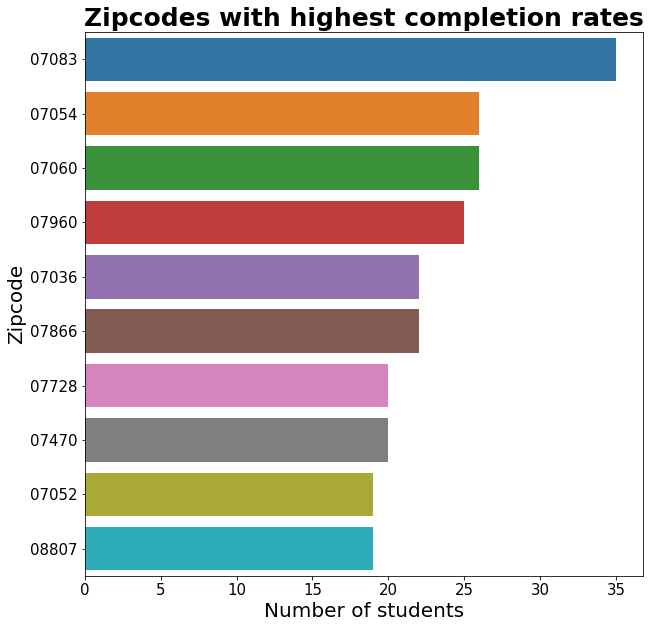

In [11]:
#look at the top 10 Zipcodes where students apply from  
y = df_Completed.Zip.value_counts().values[:10]
x = df_Completed.Zip.value_counts().index[:10]

plt.figure(figsize=(10,10))
sns.barplot(y,x)
plt.title('Zipcodes with highest completion rates',weight='bold').set_fontsize('25')
plt.ylabel("Zipcode", size=20, rotation=90)
plt.xlabel("Number of students", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [12]:
#Average distance of students top 10 completion rate
distance = []
for zipcode in x:
    distance.append(df_Completed.loc[df_Completed['Zip']==zipcode,'dist'].iloc[0])
# print(distance)
print("Average distance of students top 10 completion rate:",round(mean(distance),2),"miles")

Average distance of students top 10 completion rate: 21.16 miles


In [13]:
# Filter Students in special programs
df_SPSERV = df_Completed.loc[df_Completed["SPSERV"]!="REG"]

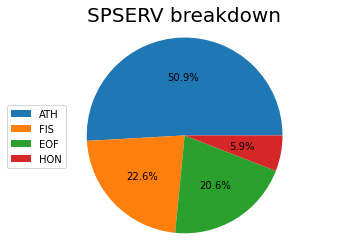

In [14]:
#See the students program breakdown 
pie_chart(df_SPSERV,"SPSERV","SPSERV breakdown")

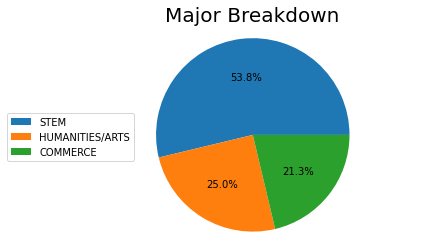

In [15]:
#See the students completion rate 
pie_chart(df_Completed,"Major","Major Breakdown")

What is the average SAT score of our students that completed ?

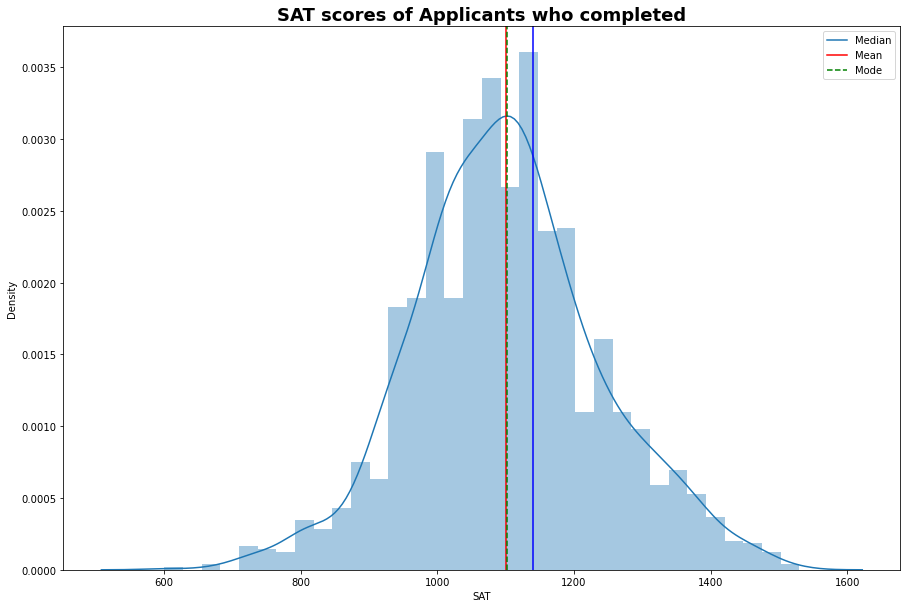

count    1795.000000
mean     1101.192201
std       137.332950
min       600.000000
25%      1010.000000
50%      1100.000000
75%      1180.000000
max      1530.000000
Name: SAT, dtype: float64

In [16]:
distribution_plot(df_Completed,'SAT','SAT scores of Applicants who completed','SAT')

What is the HS GPA of students with most completion. 

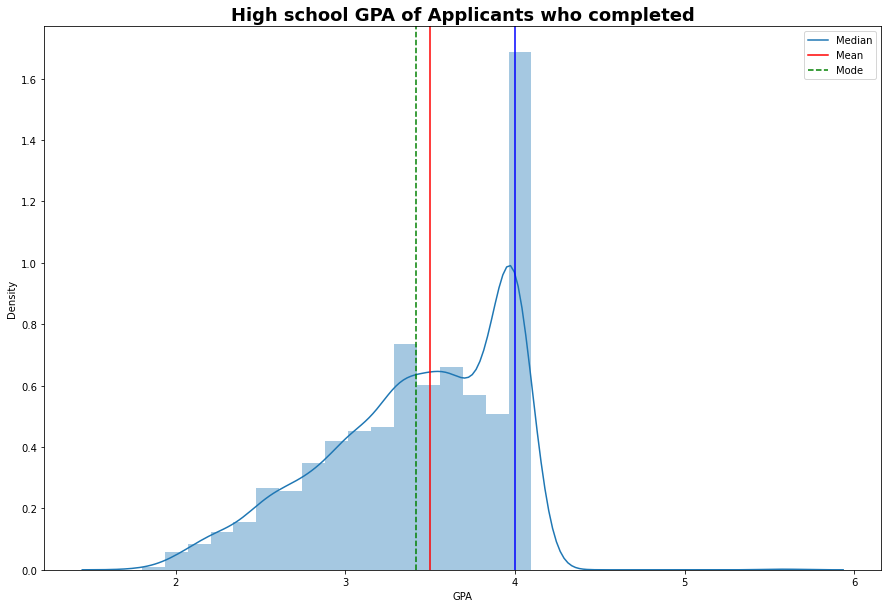

count    1795.000000
mean        3.415062
std         0.523542
min         1.800000
25%         3.060000
50%         3.500000
75%         3.910000
max         5.583000
Name: HSGPA, dtype: float64

In [17]:
distribution_plot(df_Completed,'HSGPA','High school GPA of Applicants who completed','GPA')

High median GPA justifies the fact that some (or most) of the GPA is self reported and never verified.  SAT is used for admission for this very reason as HS GPA is not very consistenet among different school districts.We can further assess this speculation by observing if there is a correlation between the two performance parameters.

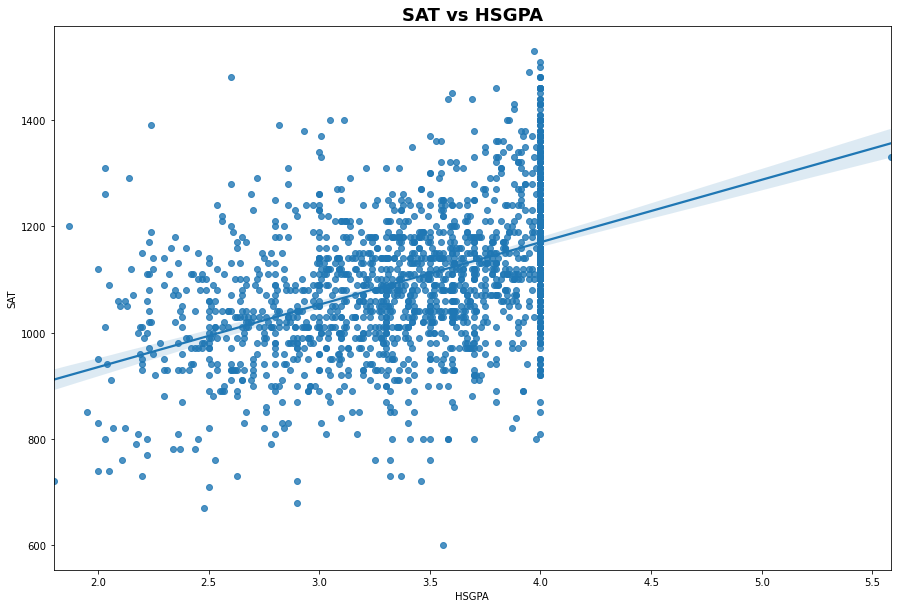

In [18]:
"""Visualtize to see correlation between SAT and HSGPA"""
plt.figure(figsize=(15,10))
sns.regplot(y=df_Completed['SAT'], x=df_Completed['HSGPA'],data=df_Completed)
plt.title('SAT vs HSGPA',weight='bold').set_fontsize('18')

In [19]:
#Calculate the correlation coefficinet between SAT and HS GPA
slope, intercept, r_value, p_value, std_err = stats.linregress(df_Completed['SAT'],df_Completed['HSGPA'])
r_value

0.4480623360871629

In [20]:
#Calculate the correlation coefficinet between SAT and HS GPA
slope, intercept, r_value, p_value, std_err = stats.linregress(df_Completed['SAT'],df_Completed['HSGPA'])
r_value

0.4480623360871629

Low correlation confirms our suspicion that HS gpa is not a very reliable performance metric due to its inconsistency across various school districts.

Let see the median Household income the zipcodes 

count      1795.000000
mean      99438.437326
std       34425.821750
min       23617.000000
25%       75000.000000
50%       98888.000000
75%      123204.000000
max      300002.000000
Name: Median Income, dtype: float64

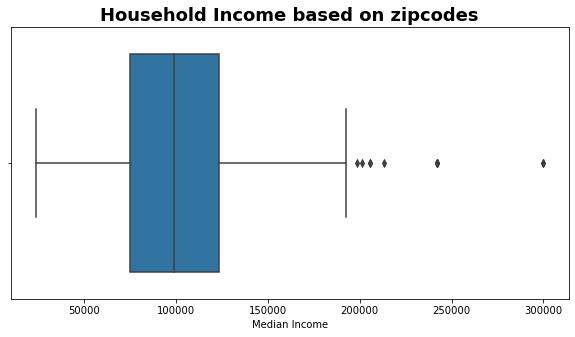

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(df_Completed['Median Income'])
plt.title("Household Income based on zipcodes",weight='bold').set_fontsize('18')
df_Completed['Median Income'].describe()

In [22]:
df_Completed.loc[df_Completed['Scholarship amount']>0]['Scholarship amount'].describe()

count     319.000000
mean     7928.971787
std      1465.012916
min      3070.000000
25%      7441.000000
50%      8159.000000
75%      8881.000000
max      9986.000000
Name: Scholarship amount, dtype: float64

### Completion rate Visuals

Its important to know What percent of students completed their coursework? These students are the ones that stay in the university for 4 years thus generating revenue each year. Our goal will be to come up with a model that will identify these students 

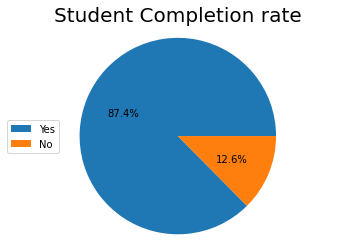

In [23]:
#See the students completion rate 
pie_chart(df,"Completed","Student Completion rate")

### Completion rate by gender

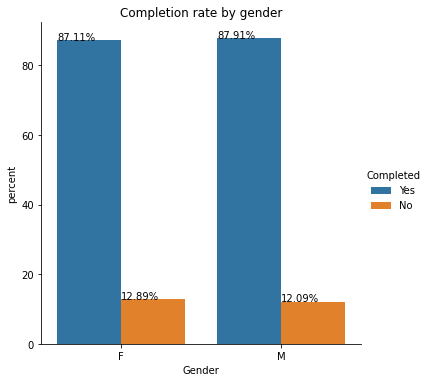

In [24]:
#Completion rate by gender
completion_catplot(df,'Gender','Completed',"Completion rate by gender")


Completion rate is more or less the same among male and female students 

### Completion rate based on scholarship

In [25]:
df_Scholarship = df.loc[df['Scholarship amount']>0] # students with scholarship


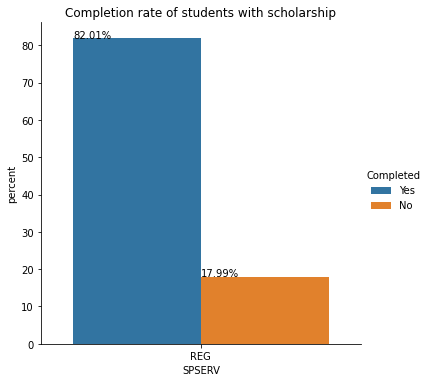

In [26]:
df_scholarship_reg = df_Scholarship.loc[df_Scholarship['SPSERV']=='REG'] # reg students with scholarship
completion_catplot(df_scholarship_reg,'SPSERV','Completed',"Completion rate of students with scholarship")


In [27]:
df_no_Scholarship = df.loc[df['Scholarship amount'] == 0] # students without scholarship

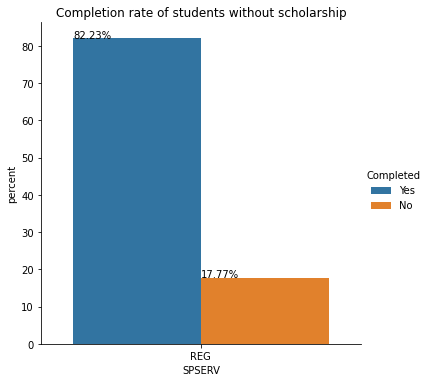

In [28]:
df_no_scholarship_reg = df_no_Scholarship.loc[df_no_Scholarship['SPSERV']=='REG'] # reg students without scholarship
completion_catplot(df_no_scholarship_reg,'SPSERV','Completed',"Completion rate of students without scholarship")


### Completion rate by major.

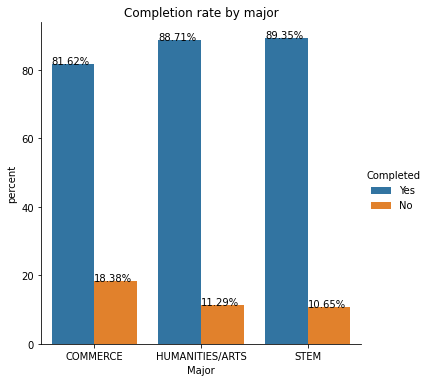

In [29]:
#Completion rate by Major
completion_catplot(df,'Major','Completed',"Completion rate by major")

### Completion rate by housing

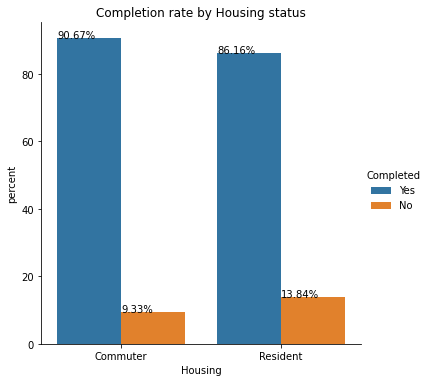

In [30]:
#Completion rate by Housing status
completion_catplot(df,'Housing','Completed',"Completion rate by Housing status")

### Completion rate by spserv

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


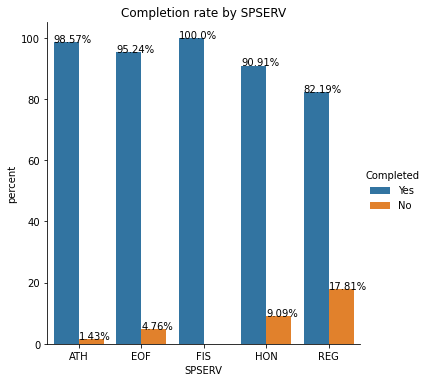

In [31]:
#Completion rate by SPSERV
completion_catplot(df,'SPSERV','Completed',"Completion rate by SPSERV")


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


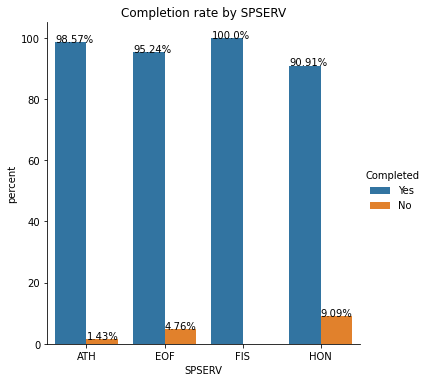

In [32]:
#Completion rate by SPSERV
completion_catplot(df.loc[df['SPSERV']!='REG'],'SPSERV','Completed',"Completion rate by SPSERV")


Based on the various categories it seems that FIS has the highest completion rate(100%) Followed by athletes(98.5%) and EOF students(95.2%) 

### Encoding categoricals 

In [33]:
df.drop(columns = ['Applicant','Address'],inplace = True)


In [34]:
#Filter string data
categorical_list = list(df.columns[(df.dtypes.values == np.dtype('object'))])
# categorical_list.remove('Zip')


In [35]:
categorical_list.remove('Zip')
categorical_list.remove('Completed')

In [36]:
categorical_list

['Gender', 'Major', 'Housing', 'SPSERV']

In [37]:
 df_categorical = df [categorical_list]

In [38]:
df_dummy = pd.get_dummies(df_categorical)

In [39]:
df_dummy.head()

Gender_F  Gender_M  Major_COMMERCE  Major_HUMANITIES/ARTS  Major_STEM  \
0         1         0               1                      0           0   
1         1         0               0                      1           0   
2         0         1               0                      0           1   
3         1         0               0                      0           1   
4         1         0               0                      1           0   

   Housing_Commuter  Housing_Resident  SPSERV_ATH  SPSERV_EOF  SPSERV_FIS  \
0                 1                 0           0           0           0   
1                 0                 1           0           0           1   
2                 0                 1           0           0           0   
3                 0                 1           0           0           0   
4                 0                 1           0           0           0   

   SPSERV_HON  SPSERV_REG  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1

In [40]:
df_en = df.join(df_dummy)

In [41]:
#Convert target variable into 1 for completed and 0 for inompletes
encoder = LabelEncoder()
df_en['Completed'] = encoder.fit_transform(df_en['Completed'])
df_en['Zip'] = encoder.fit_transform(df_en['Zip'])


In [42]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053 entries, 0 to 2052
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 2053 non-null   object 
 1   Major                  2053 non-null   object 
 2   Housing                2053 non-null   object 
 3   SAT                    2053 non-null   int64  
 4   HSGPA                  2053 non-null   float64
 5   Zip                    2053 non-null   int32  
 6   dist                   2053 non-null   float64
 7   Zip_Count              2053 non-null   int64  
 8   Median Income          2053 non-null   int64  
 9   SPSERV                 2053 non-null   object 
 10  Scholarship amount     2053 non-null   int64  
 11  Completed              2053 non-null   int32  
 12  Gender_F               2053 non-null   uint8  
 13  Gender_M               2053 non-null   uint8  
 14  Major_COMMERCE         2053 non-null   uint8  
 15  Majo

In [43]:
df_en.drop(columns = categorical_list,inplace = True)

In [44]:
df_en

SAT  HSGPA  Zip       dist  Zip_Count  Median Income  \
0     1060  3.300   89  16.519129         14          75000   
1      950  3.330   89  16.519129         14          75000   
2     1220  2.560   89  16.519129         14          75000   
3     1280  3.929   89  16.519129         14          75000   
4     1240  3.560   89  16.519129         14          75000   
...    ...    ...  ...        ...        ...            ...   
2048  1030  4.000  114  23.223581          3         134766   
2049  1280  2.840  118  35.591392          1         184556   
2050  1140  2.250  327  40.044172          1         201406   
2051  1020  2.900  342  77.849439          1          85725   
2052   910  2.690  205  33.824401          1         134375   

      Scholarship amount  Completed  Gender_F  Gender_M  Major_COMMERCE  \
0                      0          1         1         0               1   
1                      0          1         1         0               0   
2                      0          1         0         1               0   
3                   9159          1         1         0               0   
4                   6187          0         1         0               0   
...                  ...        ...       ...       ...             ...   
2048                   0          1         0         1               1   
2049                   0          0         0         1               1   
2050                   0          1         1         0               0   
2051                   0          0         0         1               1   
2052                   0          1         0         1               0   

      Major_HUMANITIES/ARTS  Major_STEM  Housing_Commuter  Housing_Resident  \
0                         0           0                 1                 0   
1                         1           0                 0                 1   
2                         0           1                 0                 1   
3                         0           1                 0                 1   
4                         1           0                 0                 1   
...                     ...         ...               ...               ...   
2048                      0           0                 0                 1   
2049                      0           0                 0                 1   
2050                      0           1                 0                 1   
2051                      0           0                 0                 1   
2052                      1           0                 0                 1   

      SPSERV_ATH  SPSERV_EOF  SPSERV_FIS  SPSERV_HON  SPSERV_REG  
0              0           0           0           0           1  
1              0           0           1           0           0  
2              0           0           0           0           1  
3              0           0           0           0           1  
4              0           0           0           0           1  
...          ...         ...         ...         ...         ...  
2048           0           0           0           0           1  
2049           0           0           0           0           1  
2050           0           0           0           0           1  
2051           0           0           0           0           1  
2052           0           0           1           0           0  

[2053 rows x 20 columns]

In [45]:
# Set Predictor and response  
y = df_en['Completed']
X = df_en.drop('Completed', axis=1)
        

In [46]:
#Create training/testing data with 30 % test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


## Modelling

### Vanilla DT model

In [47]:
DTC_model1 = DecisionTreeClassifier(random_state=42)


In [48]:
DTC_model1.fit(X_train, y_train)
;

''

In [49]:
y_test_pred = DTC_model1.predict(X_test)

In [50]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8829702201516398
Accuracy Score Test: 0.8798701298701299
ROC_AUC Test: 0.7532467532467533


In [51]:
# Look at the feature contribution to our model.
importances = DTC_model1.feature_importances_
indices = np.argsort(importances)[::-1]
drop_feature_list=[]
# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(i + 1, X_train.columns[indices[i]], importances[indices[i]])
    if importances[indices[i]]< 0.01:
        drop_feature_list.append(X_train.columns[indices[i]])#track features that contribute less than 1%

Feature ranking:
1 SAT 0.21442193594644499
2 Scholarship amount 0.18714307445903064
3 Median Income 0.17662729315926007
4 dist 0.09385720822622844
5 Zip_Count 0.08501271173836272
6 HSGPA 0.07502974410019489
7 SPSERV_REG 0.07197163139894162
8 Zip 0.06858803697991686
9 Major_STEM 0.01632115882268165
10 Gender_F 0.006549801678069973
11 Gender_M 0.0031605201112010423
12 Housing_Resident 0.0013168833796671012
13 Major_HUMANITIES/ARTS 0.0
14 SPSERV_HON 0.0
15 Housing_Commuter 0.0
16 SPSERV_ATH 0.0
17 SPSERV_EOF 0.0
18 SPSERV_FIS 0.0
19 Major_COMMERCE 0.0


In [52]:
importances[indices[0]]

0.21442193594644499

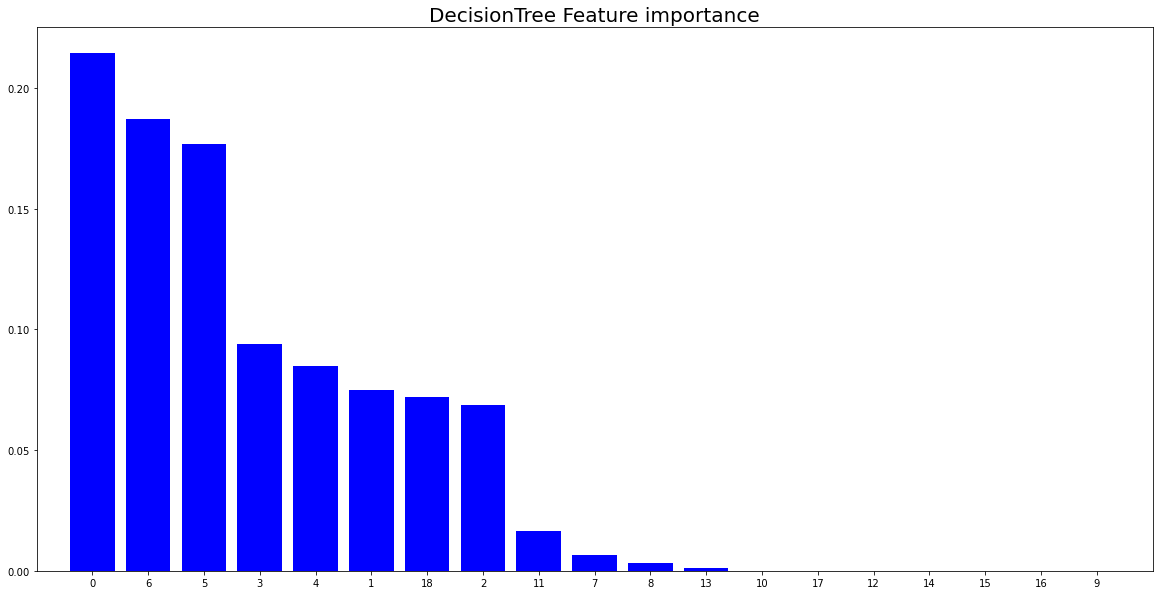

In [53]:
# Plot the feature importances 
plt.figure(figsize=(20,10))
plt.title("DecisionTree Feature importance",size=20)
plt.bar(range(X_train.shape[1]), importances[indices],color="b", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


Seems the the top 5 (SAT,Scholarship amount,Median Income,Zip_Count,dist)contributing features account for more than 65% of the model predictions. Although we might have a class imbalance, especially considering our Precision is so high , we will generate some synthetic data to remedy this by oversampling the minority class..

In [54]:
# summarize distribution
counter = Counter(y)
for j,k in counter.items():
    per = k / len(y) * 100
    print('n=%d HR: %s, (%.3f%%)' % ( k,j, per))
# plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

n=1795 HR: 1, (87.433%)
n=258 HR: 0, (12.567%)


### DT Model using Resampling

In [55]:
# oversampling minority class and undersampling majority class
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# summarize distribution
counter = Counter(y_train_resampled)
for j,k in counter.items():
    per = k / len(y_train_resampled) * 100
    print('n=%d %s, (%.3f%%)' % ( k,j, per))
# plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

n=1256 1, (50.000%)
n=1256 0, (50.000%)


In [56]:

DTC_model2 = DecisionTreeClassifier(random_state=42)
DTC_model2.fit(X_train_resampled, y_train_resampled)
y_test_pred = DTC_model2.predict(X_test)
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8665094339622641
Accuracy Score Test: 0.8603896103896104
ROC_AUC Test: 0.7309833024118739


The model accuracy scores are more or less the same , in fact its is slightly lower so class imbalance is not an issue. 

In [57]:
#We will use three repeats of 10-fold cross-validation,
#4-fold cross-validation is applied 5 times fitting and evaluating 20 models on the dataset.
DTC_model3 = DecisionTreeClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=42)
scores = cross_val_score(DTC_model3,X_train_resampled, y_train_resampled, scoring='f1', cv=cv, n_jobs=-1)
#Check the Accuray score of the 30 models 
print('Mean f1: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean f1: 0.929 (0.010)


In [58]:
DTC_model4 = DecisionTreeClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=42)
scores = cross_val_score(DTC_model4,X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
#Check the Accuray score of the 30 models 
print('Mean f1: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean f1: 0.936 (0.011)


The average f1 from resampling is higher then our vanilla model but resampling using orignial data is higher than resampled data. Higher accuracy with resampled data implies our model will perform better with new data.

### DT Model using recursive feature elimination with synthetic data

In [59]:
# Using RFECV look at the cross-validated score performance for the training data
DTC_model5 = DecisionTreeClassifier(random_state=42)
# The "accuracy" scoring translates to correct classifications in training data folds
rfecv = RFECV(estimator=DTC_model5, step=1, cv=StratifiedKFold(n_splits=5),scoring='f1')
rfecv.fit(X_train_resampled, y_train_resampled)
;

''

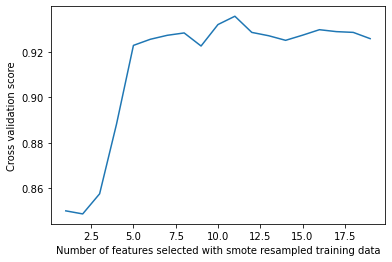

In [60]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected with smote resampled training data")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [61]:
# features to keep /remove based on training data and RFECV
columns_keep=[]
print("Optimal number of features : %d" % rfecv.n_features_)
for i in range(X_train.shape[1]):
    if rfecv.support_[i] ==True:
        print('Column %.f,Feature to keep: %s, Selected %s, Rank: %.3f' % (i,X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))
        columns_keep.append(i)

Optimal number of features : 11
Column 0,Feature to keep: SAT, Selected True, Rank: 1.000
Column 1,Feature to keep: HSGPA, Selected True, Rank: 1.000
Column 2,Feature to keep: Zip, Selected True, Rank: 1.000
Column 3,Feature to keep: dist, Selected True, Rank: 1.000
Column 4,Feature to keep: Zip_Count, Selected True, Rank: 1.000
Column 5,Feature to keep: Median Income, Selected True, Rank: 1.000
Column 6,Feature to keep: Scholarship amount, Selected True, Rank: 1.000
Column 7,Feature to keep: Gender_F, Selected True, Rank: 1.000
Column 9,Feature to keep: Major_COMMERCE, Selected True, Rank: 1.000
Column 13,Feature to keep: Housing_Resident, Selected True, Rank: 1.000
Column 18,Feature to keep: SPSERV_REG, Selected True, Rank: 1.000


In [62]:
y_test_pred=rfecv.predict(X_test)

In [63]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8700109291356964
Accuracy Score Test: 0.862012987012987
ROC_AUC Test: 0.7541743970315399


F1 score is more or less the same so we can conclude the model is able to perform more or less the same despite the class , imabalance. We can see that the cv score for feature importance is more or less constant after 11 features.  

### DT Model using recursive feature elimination with original data

In [64]:
# Using RFECV look at the cross-validated score performance for the training data
DTC_model6 = DecisionTreeClassifier(random_state=42)
# The "accuracy" scoring translates to correct classifications in training data folds
rfecv = RFECV(estimator=DTC_model6, step=1, cv=StratifiedKFold(n_splits=5),scoring='f1')
rfecv.fit(X_train, y_train)
;

''

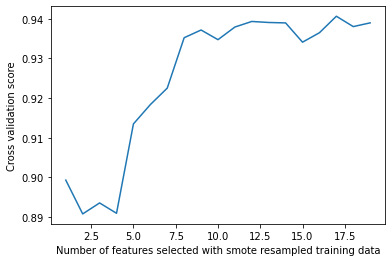

In [65]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected with smote resampled training data")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [66]:
# features to keep /remove based on training data and RFECV
columns_keep=[]
print("Optimal number of features : %d" % rfecv.n_features_)
for i in range(X_train.shape[1]):
    if rfecv.support_[i] ==True:
        print('Column %.f,Feature to keep: %s, Selected %s, Rank: %.3f' % (i,X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))
        columns_keep.append(i)

Optimal number of features : 17
Column 0,Feature to keep: SAT, Selected True, Rank: 1.000
Column 1,Feature to keep: HSGPA, Selected True, Rank: 1.000
Column 2,Feature to keep: Zip, Selected True, Rank: 1.000
Column 3,Feature to keep: dist, Selected True, Rank: 1.000
Column 4,Feature to keep: Zip_Count, Selected True, Rank: 1.000
Column 5,Feature to keep: Median Income, Selected True, Rank: 1.000
Column 6,Feature to keep: Scholarship amount, Selected True, Rank: 1.000
Column 7,Feature to keep: Gender_F, Selected True, Rank: 1.000
Column 8,Feature to keep: Gender_M, Selected True, Rank: 1.000
Column 10,Feature to keep: Major_HUMANITIES/ARTS, Selected True, Rank: 1.000
Column 11,Feature to keep: Major_STEM, Selected True, Rank: 1.000
Column 12,Feature to keep: Housing_Commuter, Selected True, Rank: 1.000
Column 13,Feature to keep: Housing_Resident, Selected True, Rank: 1.000
Column 14,Feature to keep: SPSERV_ATH, Selected True, Rank: 1.000
Column 15,Feature to keep: SPSERV_EOF, Selected T

In [67]:
y_test_pred=rfecv.predict(X_test)

In [68]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8822425571392427
Accuracy Score Test: 0.8782467532467533
ROC_AUC Test: 0.7578849721706864


F1 and accuracy are more or less the same but ROC_AUC went up slightly.

Decisiton tree model 5 which uses smote data with recursive feature elimination and repeated cross validation performed the best with a f1 of close to 90% and roc_auc of nearly 80%

Roc_auc is about the same at DTC model5, F1 is lower and accuracy is higher which suggests the DTC model is less sensitive 

### Hyperparameter Tuning

In [74]:
# criterion : "gini", "entropy"
# max_depth : The maximum depth of the tree.
# min_samples_split : The minimum number of samples required to split an internal node:
# min_samples_leaf : The minimum number of samples required to be at a leaf node. 
parameters = {"criterion": ["gini", "entropy"],
              "max_depth": [2,4,6,8,10,12],
              "splitter":["best","random"],
             "max_features":list(range(0,23)),
             "class_weight":["balanced", "None"]}
DTC_model_hp =DecisionTreeClassifier()
grid_search = GridSearchCV(DTC_model_hp, parameters, n_jobs=-1, cv=cv, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)
;

''

In [75]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 19, 'splitter': 'best'}
0.9324882388090625


In [76]:
y_test_pred = grid_search.best_estimator_.predict(X_test)


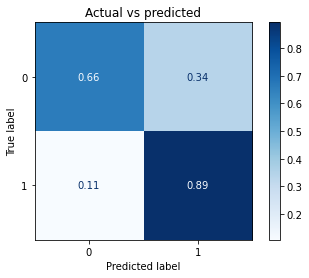

In [147]:
disp = plot_confusion_matrix(grid_search, X_test, y_test,
                                 cmap=plt.cm.Blues,normalize = "true")
title ='Actual vs predicted';
disp.ax_.set_title(title)
plt.show()

### Bagging classifier

In [69]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=12), 
                                 n_estimators=20)

In [70]:
bagged_tree.fit(X_train, y_train)
;

''

In [71]:
# Testing accuracy score
y_test_pred = bagged_tree.predict(X_test)

In [72]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8940138604059119
Accuracy Score Test: 0.8928571428571429
ROC_AUC Test: 0.7662337662337662


### Random Forest classifier

#### Vanilla model

In [77]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 12)
forest.fit(X_train_resampled, y_train_resampled)
;

''

In [78]:
y_test_pred = forest.predict(X_test)

In [79]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8773088945723216
Accuracy Score Test: 0.875
ROC_AUC Test: 0.7337662337662337


#### RF using cross validation and recursive feature elimination with original data 

In [80]:
# Using RFECV look at the cross-validated score performance for the training data
# The "accuracy" scoring translates to correct classifications in training data folds
rfecv = RFECV(estimator=forest, step=1, cv=StratifiedKFold(n_splits=5),scoring='f1')
rfecv.fit(X_train, y_train)
;

''

In [81]:
# features to keep /remove based on training data and RFECV
print("Optimal number of features : %d" % rfecv.n_features_)
for i in range(X_train.shape[1]):
    if rfecv.support_[i] ==True:
        print('Column %.f,Feature to keep: %s, Selected %s, Rank: %.3f' % (i,X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))
        

Optimal number of features : 12
Column 0,Feature to keep: SAT, Selected True, Rank: 1.000
Column 1,Feature to keep: HSGPA, Selected True, Rank: 1.000
Column 2,Feature to keep: Zip, Selected True, Rank: 1.000
Column 3,Feature to keep: dist, Selected True, Rank: 1.000
Column 4,Feature to keep: Zip_Count, Selected True, Rank: 1.000
Column 5,Feature to keep: Median Income, Selected True, Rank: 1.000
Column 6,Feature to keep: Scholarship amount, Selected True, Rank: 1.000
Column 7,Feature to keep: Gender_F, Selected True, Rank: 1.000
Column 8,Feature to keep: Gender_M, Selected True, Rank: 1.000
Column 9,Feature to keep: Major_COMMERCE, Selected True, Rank: 1.000
Column 11,Feature to keep: Major_STEM, Selected True, Rank: 1.000
Column 18,Feature to keep: SPSERV_REG, Selected True, Rank: 1.000


In [82]:
y_test_pred=rfecv.predict(X_test)

In [83]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8748778876496096
Accuracy Score Test: 0.8847402597402597
ROC_AUC Test: 0.6669758812615956


Although we dont have too many features i would like to see if we can model with less features and comparable accuracy

#### RF using cross validation and recursive feature elimination with smote data 

In [84]:
# Using RFECV look at the cross-validated score performance for the training data
# The "accuracy" scoring translates to correct classifications in training data folds
rfecv = RFECV(estimator=forest, step=1, cv=StratifiedKFold(n_splits=5),scoring='f1')
rfecv.fit(X_train_resampled, y_train_resampled)
;

''

In [85]:
# features to keep /remove based on training data and RFECV
print("Optimal number of features : %d" % rfecv.n_features_)
for i in range(X_train.shape[1]):
    if rfecv.support_[i] ==True:
        print('Column %.f,Feature to keep: %s, Selected %s, Rank: %.3f' % (i,X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))
        

Optimal number of features : 9
Column 0,Feature to keep: SAT, Selected True, Rank: 1.000
Column 3,Feature to keep: dist, Selected True, Rank: 1.000
Column 4,Feature to keep: Zip_Count, Selected True, Rank: 1.000
Column 5,Feature to keep: Median Income, Selected True, Rank: 1.000
Column 6,Feature to keep: Scholarship amount, Selected True, Rank: 1.000
Column 7,Feature to keep: Gender_F, Selected True, Rank: 1.000
Column 9,Feature to keep: Major_COMMERCE, Selected True, Rank: 1.000
Column 11,Feature to keep: Major_STEM, Selected True, Rank: 1.000
Column 18,Feature to keep: SPSERV_REG, Selected True, Rank: 1.000


In [86]:
y_test_pred=rfecv.predict(X_test)

In [87]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.899328355357601
Accuracy Score Test: 0.8944805194805194
ROC_AUC Test: 0.8116883116883117


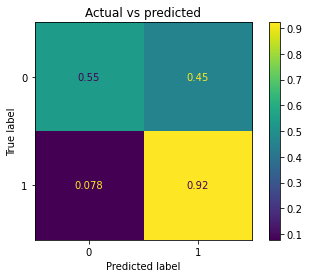

In [139]:
# plot confusion Matrix
disp = plot_confusion_matrix(forest, X_test, y_test,normalize='true')
title ='Actual vs predicted'
disp.ax_.set_title(title)
disp.ax_.set_title(title)
# print(title)
# print(disp.confusion_matrix)
plt.show()

## Conclusion and Future Work:

 According to our analysis an ideal applicant would have a SAT score of around 1100 and lives within 21 miles of the campus. Applicants from Zip codes with a median household income of 98,888 have high completion rates. A student in any of the Special serv programs has higher completion rate than a regular student. Commerce majors have higher completion rates than any other major category. Female students have a slighlt higher completion rate than their male counterparts. Our model is able to identify students who are likely to complete with a 90% accuracy.


 For Future work ,We can use student highschool course work /grades to assess students prepradness for college which directly impacts completion rate.I would like to use Student's college GPA on a semester basis with semesters after which a student drops out to determine drop out risk rates.I would also like to identify key zipcodes to recruit students 